# Dirichlet Process - Gaussian Mixture Model
---

ThetaLog.com

## 1. Tạo tập dữ liệu nhân tạo

In [1]:
import numpy as np
import scipy
from scipy import stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Hiện tại mình đang thiết một matplotlib style riêng
# khi nào hoàn tất mình sẽ chia sẻ :'>

plt.style.use('bmh')
#plt.style.use('thetalog')

np.random.seed(11)

s0 = 3.00 # độ lệch chuẩn giữa tâm các cụm
ss = 0.65 # độ lệch chuẩn giữa các điểm trong cụm

mean_1 = multivariate_normal.rvs(mean=np.array([0,0])) * s0
mean_2 = multivariate_normal.rvs(mean=np.array([0,0])) * s0
mean_3 = multivariate_normal.rvs(mean=np.array([0,0])) * s0
mean_4 = multivariate_normal.rvs(mean=np.array([0,0])) * s0

X1 = mean_1 + multivariate_normal.rvs(mean=np.array([0,0]), size=100) * ss
X2 = mean_2 + multivariate_normal.rvs(mean=np.array([0,0]), size=60) * ss
X3 = mean_3 + multivariate_normal.rvs(mean=np.array([0,0]), size=40) * ss
X4 = mean_4 + multivariate_normal.rvs(mean=np.array([0,0]), size=65) * ss
# nhãn cho các điểm dữ liệu thuộc về cụm tương ứng
truth = [0]*100 + [1]*60 + [2]*40 + [3]*65

X = np.concatenate((X1, X2, X3, X4))

Vẽ X:

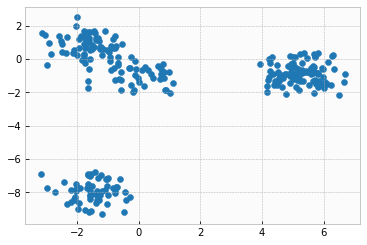

In [2]:
plt.scatter(X[:,0],X[:,1])
plt.show()

Vẽ X với nhãn của cụm:

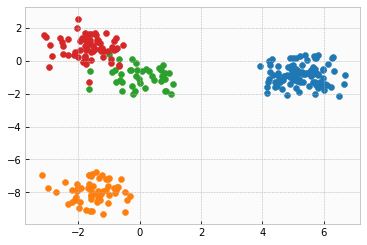

In [3]:
plt.scatter(X1[:,0], X1[:,1])
plt.scatter(X2[:,0], X2[:,1])
plt.scatter(X3[:,0], X3[:,1])
plt.scatter(X4[:,0], X4[:,1])
plt.show()

## 2. Cài đặt Gaussian (với Gaussian-Wishart làm phân bố tiên nghiệm)

Phần cài đặt phân bố $p(x_i | \mathbf{z}_{-i}, \mathbf{x}_{-i}, z_i = k, \lambda)$ với dùng phân bố cụm Gaussian (dùng Gaussian-Wishart làm tiên nghiệm cho tham số) cho từng phân bố con trong mô hình trộn.

Bạn đọc tham khảo phần chi tiết cài đặt: https://www.stats.ox.ac.uk/~teh/research/notes/GaussianInverseWishart.pdf

In [4]:
class _DPMulNormal:
    """
    Lớp _DPMulNormal
    Cài đặt phân bố Normal (Gaussian) nhiều chiều cho mô hình DPMM
    (cùng tiên nghiệm liên hợp Gaussian-Wishart conjugate prior)
    """
    def __init__(self, D=2, s0 = 5.0, ss = 0.65):
        """
        Phương thức khởi tạo

        :param D: int - số chiều
        :param s0: float - độ lệch chuẩn giữa các cụm
        :param ss: float - độ lệch chuẩn giữa các điểm trong cụm
        """
        self.dd = D
        self.vv = 5
        self.vc = np.eye(D)
        self.uu = np.zeros(shape=(D, 1))
        self.nn = 0
        self.ws = self.vc * self.vv
        self.rr = 1.0 / (s0**2/ss**2)
        self.cc = scipy.linalg.cholesky(self.ws + self.rr * self.uu @ self.uu.T)
        self.xx = np.zeros(shape=(D,1))
    def add_point(self, x):
        """
        Thêm điểm

        :param x: np.array - vectơ cột D x 1
        """
        self.nn += 1
        self.rr += 1
        self.vv += 1
        self.cc = self.__cholupdate(self.cc, x, '+')
        self.xx += x
    def del_point(self, x):
        """
        Giảm điểm

        :param x: np.array - vectơ cột D x 1
        """
        self.nn -= 1
        self.rr -= 1
        self.vv -= 1
        self.cc = self.__cholupdate(self.cc, x, '-')
        self.xx -= x
    def logpredictive(self, x):
        """
        Log xác suất

        :param x: np.array - vectơ cột D x 1
        """
        dd = self.dd
        nn = self.nn
        rr = self.rr
        vv = self.vv
        cc = self.cc
        xx = self.xx
        lp = self.__z(dd,nn+1,rr+1,vv+1,self.__cholupdate(cc,x),xx+x) \
             - self.__z(dd,nn, rr, vv ,cc ,xx)
        return lp
    def __cholupdate(self, R_current, x_update, sign='+'):
        """
        Hàm bổ trợ phân rã Cholesky
        + Rank-one update
        - Rank-one downdate

        Giả sử R1 là kết quả của
        R1 = cholesky_decomposition(A)
        Ta muốn tìm kết quả
        R2 = cholesky_decomposition(A + x @ x.T)
        Thì thay vì tính toán lại từ đầu
        R2 = __cholupdate(R1, x, '+')
        (tương tự với trường hợp downdate)

        :param R_current: np.array - lời giải trước
        :param x_update: np.array - vectơ cập nhật (+x@x.T hoặc - x@x.T)
        :param sign: str - '+' hoặc '-'

        :return R: lời giải rank-one update (downdate) tương ứng
        """
        R = R_current.copy()
        x = x_update.copy()
        n = len(x)

        for k in range(n):
            if sign == '+':
                r = np.sqrt(R[k, k]**2 + x[k, 0]**2)
            else:
                r = np.sqrt(R[k, k]**2 - x[k, 0]**2)
            c = r / R[k, k]
            s = x[k, 0] / R[k, k]

            R[k,k] = r

            if k !=n-1:
                if sign == '+':
                    R[(k+1):n, k] = (R[(k+1):n, k] + s * x[(k+1):n, 0]) / c
                else:
                    R[(k+1):n, k] = (R[(k+1):n, k] - s * x[(k+1):n, 0]) / c
                x[(k+1):n, 0] = c * x[(k+1):n, 0] - s * R[(k+1):n, k]
        return R
    def __z(self, dd, nn, rr, vv, cc, xx):
        """
        Hàm bổ trợ để công thức nhìn gọn
        """
        zz = - nn*dd/2*np.log(np.pi) - dd/2*np.log(rr) - \
             vv*np.sum(np.log(np.diag(self.__cholupdate(cc, xx / np.sqrt(rr),'-')))) \
             + np.sum(scipy.special.loggamma((vv-(np.arange(0,dd, 1)))/2))
        return zz

## 3. Cài đặt trường hợp DP-GMM hữu hạn

In [5]:
def finite_dp_gmm(X, K, z_init=None, alpha=1.0, max_iters=100):
    """
    (hữu hạn) Dirichlet Process - Gaussian Mixture Model

    :param X: np.array - dữ liệu N x D (N dòng, D cột - chiều)
    :param K: int - số cụm
    :param z_init: np.array - nhãn của điểm khởi tạo
    :param alpha: float - hệ số alpha độ tập trung
    :param max_iters: int - số vòng lặp

    :return z: kết quả phân cụm
    """
    N = len(X)
    D = X.shape[1]
    n_points_cluster = np.zeros(K, dtype=int)

    if z_init is None:
        z = np.random.randint(0, K, size=N)
    else:
        z = z_init

    # Mỗi cụm là một phân bố Gaussian nhiều chiều
    clusters = [_DPMulNormal() for _ in range(K)]

    # Khởi tạo thêm điểm vào cụm
    for i in range(N):
        c = z[i]
        n_points_cluster[c] += 1
        clus = clusters[c]
        clus.add_point(X[i].reshape(D,1))

    # Lặp
    for _ in range(max_iters):
        # Duyệt qua từng điểm dữ liệu
        for i in range(N):
            z_i = z[i]
            x_i = X[i].reshape(D,1)
            current_clus = clusters[z_i]

            # Xóa điểm x_i ra khỏi cụm hiện tại
            current_clus.del_point(x_i)
            n_points_cluster[z_i] -= 1

            # Tính xác suất theo hàm log rồi mũ lên
            prob = np.log(alpha/float(K) + n_points_cluster)
            for j in range(len(clusters)):
                prob[j] = prob[j] + clusters[j].logpredictive(x_i)
            prob = np.exp(prob - np.max(prob)) # ổn định tính toán số
            prob = prob / prob.sum()

            # Gieo ngẫu nhiên x_i thuộc về cụm nào, theo phân bố rời rạc prob
            current_dist = stats.rv_discrete(values=(list(range(len(prob))), prob))
            z_new = current_dist.rvs(size=1)
            z_new = int(z_new)

            # Thêm x_i vào cụm z_new
            clusters[z_new].add_point(x_i)
            n_points_cluster[z_new] += 1
            z[i] = z_new
    return z

Thử chạy thử xem:

In [6]:
np.random.seed(7)
K = 4
z = finite_dp_gmm(X, K, max_iters=50)

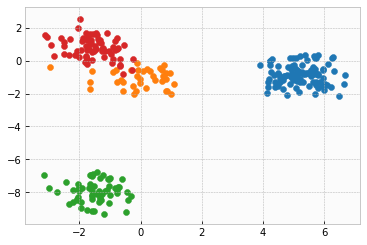

In [7]:
for c in np.unique(z):
    plt.scatter(X[z==c,0], X[z==c,1])
plt.show()

## 4. Cài đặt trường hợp DP-GMM vô hạn

In [8]:
def infinite_dp_gmm(X, K=25, z_init=None, alpha=1.0, max_iters=100):
    """
    (vô hạn) Dirichlet Process - Gaussian Mixture Model

    :param X: np.array - dữ liệu N x D (N dòng, D cột - chiều)
    :param K: int - số cụm (khởi tạo là một con số rất lớn)
    :param z_init: np.array - nhãn của điểm khởi tạo
    :param alpha: float - hệ số alpha độ tập trung
    :param max_iters: int - số vòng lặp

    :return z: kết quả phân cụm
    """
    N = len(X)
    D = X.shape[1]

    if z_init is None:
        z = np.random.randint(0, K, size=N)
    else:
        z = z_init
        K = len(np.unique(z))
    n_points_cluster = [0] * K

    # Mỗi cụm là một phân bố Gaussian nhiều chiều
    clusters = [_DPMulNormal() for _ in range(K)]
    dummy_dist = _DPMulNormal()


    for i in range(N):
        c = z[i]
        n_points_cluster[c] += 1
        clus = clusters[c]
        clus.add_point(X[i].reshape(D, 1))

    for _ in range(max_iters):
        for i in range(N):
            z_i = z[i]
            x_i = X[i].reshape(D, 1)

            current_clus = clusters[z_i]

            # Xóa điểm x_i ra khỏi cụm hiện tại
            current_clus.del_point(x_i)
            n_points_cluster[z_i] -= 1

            # Nếu cụm hiện tại không có bất kì điểm nào thì xóa hẳn nó
            if n_points_cluster[z_i] == 0:
                del n_points_cluster[z_i]
                del clusters[z_i]
                z[z > z_i] -= 1


            # Tính xác suất theo hàm log rồi mũ lên
            # Lưu ý: prob[-1], len(prob) = len(clusters) + 1
            # prob[-1] là xác suất thêm cụm mới
            prob = np.log(np.array(n_points_cluster + [alpha]))
            for j in range(len(clusters)):
                prob[j] = prob[j] + clusters[j].logpredictive(x_i)
            prob[-1] = prob[-1] + dummy_dist.logpredictive(x_i)
            prob = np.exp(prob - np.max(prob)) # ổn định tính toán số
            prob = prob / prob.sum()

            # Gieo ngẫu nhiên x_i thuộc về cụm nào, theo phân bố rời rạc prob
            current_dist = stats.rv_discrete(values=(list(range(len(prob))), prob))
            z_new = current_dist.rvs(size=1)
            z_new = int(z_new)

            if z_new == len(prob) - 1:
                # Thêm cụm mới nếu z rơi vào cụm mới
                clusters.append(_DPMulNormal())
                n_points_cluster.append(0)

            # Thêm điểm vào cụm
            clusters[z_new].add_point(x_i)
            n_points_cluster[z_new] += 1
            z[i] = z_new
    return z

Thử chạy thử xem:

In [9]:
np.random.seed(7)
# Mặc định K = 25
z = infinite_dp_gmm(X, max_iters=50)

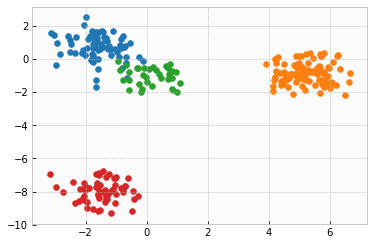

In [10]:
for c in np.unique(z):
    plt.scatter(X[z==c,0], X[z==c,1])
plt.show()